<a href="https://colab.research.google.com/github/aamirattara/Quantitative-Finance/blob/main/Time_Seies_Analysis_and_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 18.1 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
100%|██████████| 50/50 [00:45<00:00,  1.09it/s]



=== Rolling Forecast Results ===
RMSE: 4.87
MAE : 4.00


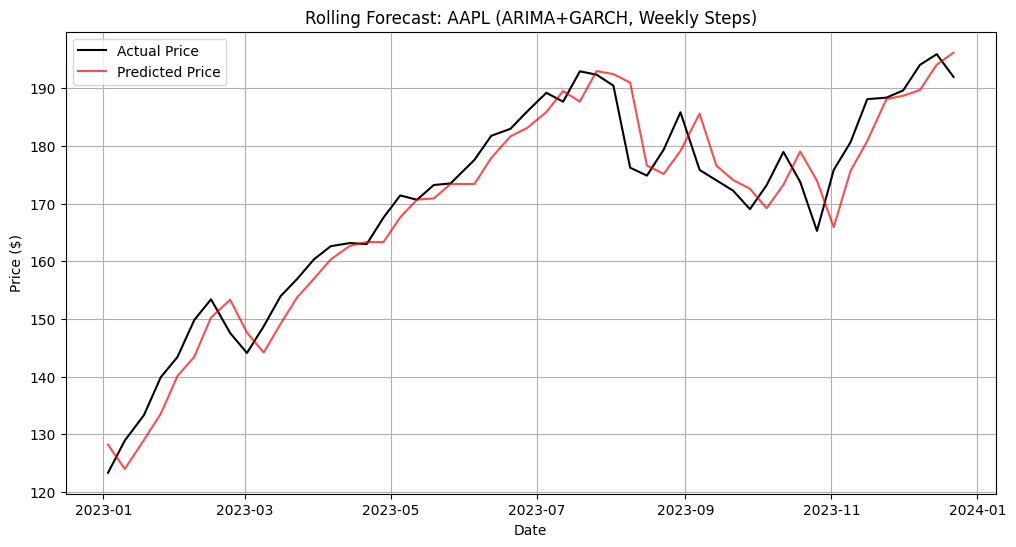

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")  # suppress noisy ARIMA/GARCH warnings

# ---------------- PARAMETERS ----------------
ticker = "AAPL"
train_start, train_end = "2018-01-01", "2022-12-31"
test_start, test_end   = "2023-01-01", "2023-12-31"
min_history = 500   # at least 500 days history before fitting

# ---------------- DOWNLOAD DATA ----------------
data = yf.download(ticker, start=train_start, end=test_end, auto_adjust=True)
if "Close" in data.columns:
    data = data.rename(columns={"Close": "Adj Close"})

# Compute log returns
data["Returns"] = np.log(data["Adj Close"] / data["Adj Close"].shift(1))
data = data.dropna()

train_data = data.loc[train_start:train_end]
test_data  = data.loc[test_start:test_end]

# ---------------- ROLLING FORECAST ----------------
history = train_data["Returns"].copy()
last_price = train_data["Adj Close"].iloc[-1]

predicted_prices = []
actual_prices = []

# Step through test data weekly
for date, row in tqdm(test_data.iloc[::5].iterrows(), total=len(test_data)//5):
    if len(history) < min_history:
        # not enough data yet
        history = pd.concat([history, pd.Series([row["Returns"]], index=[date])])
        continue

    # --- Fit ARIMA on returns ---
    arma_model = ARIMA(history.astype(float), order=(1,0,1))
    arma_result = arma_model.fit()

    # --- GARCH on ARIMA residuals ---
    residuals = arma_result.resid
    garch_model = arch_model(residuals, vol="GARCH", p=1, q=1, rescale=True)
    garch_result = garch_model.fit(disp="off")

    # --- Forecast next-day return ---
    arma_forecast = arma_result.get_forecast(steps=1)
    predicted_return = arma_forecast.predicted_mean.iloc[0]

    # --- Forecast volatility ---
    garch_forecast = garch_result.forecast(horizon=1)
    predicted_var = garch_forecast.variance.iloc[-1, 0]
    predicted_vol = np.sqrt(predicted_var)

    # --- Forecast price ---
    forecasted_price = last_price * np.exp(predicted_return)
    predicted_prices.append(forecasted_price)

    # --- Save actual price ---
    actual_price = row["Adj Close"]
    actual_prices.append(actual_price)

    # --- Update rolling history ---
    history = pd.concat([history, pd.Series([row["Returns"]], index=[date])])
    history = history.astype(float)
    last_price = actual_price

# ---------------- RESULTS ----------------
results = pd.DataFrame({
    "Actual": actual_prices,
    "Predicted": predicted_prices
}, index=test_data.iloc[::5].index)

rmse = np.sqrt(((results["Predicted"] - results["Actual"])**2).mean())
mae  = np.abs(results["Predicted"] - results["Actual"]).mean()

print("\n=== Rolling Forecast Results ===")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")

# ---------------- PLOT ----------------
plt.figure(figsize=(12,6))
plt.plot(results.index, results["Actual"], label="Actual Price", color="black")
plt.plot(results.index, results["Predicted"], label="Predicted Price", color="red", alpha=0.7)
plt.title(f"Rolling Forecast: {ticker} (ARIMA+GARCH, Weekly Steps)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()


Uses every 5th trading day → speeds up 5×.

Ensures history.astype(float) avoids dtype errors.

Sets min_history=500 to prevent fitting on tiny samples.

Suppresses warnings for cleaner output.